## Project 5: WAM News Prediction of  California's Gubernatorial 2021 Election

### Modeling - RandomForest

### Import Libraries

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

### Load Data

In [36]:
# read data
df=pd.read_csv('../data/2018_gov_features.csv', index_col=0)
df.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2]
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]


In [37]:
df.shape

(3739, 13)

In [38]:
# check null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739 entries, 392782 to 452724
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dist          3739 non-null   int64 
 1   ownhome       3739 non-null   object
 2   pid3          3739 non-null   object
 3   gender        3739 non-null   object
 4   age           3739 non-null   int64 
 5   educ          3739 non-null   object
 6   race          3739 non-null   object
 7   faminc        3739 non-null   object
 8   marstat       3739 non-null   object
 9   newsint       3739 non-null   object
 10  approval_gov  3739 non-null   object
 11  ideo5         3739 non-null   object
 12  voted_gov     3739 non-null   object
dtypes: int64(2), object(11)
memory usage: 409.0+ KB


In [39]:
# baseline accuracy
df['voted_gov'].value_counts(normalize=True)

[Democrat / Candidate 1]       0.611661
[Republican / Candidate 2]     0.368013
I Did Not Vote In This Race    0.009896
Not Sure                       0.006686
Other                          0.003744
Name: voted_gov, dtype: float64

Baseline accuracy is 61.2%. We have unimbalanced data.

In [40]:
# drop other categories, make it a binary classification
df = df[(df.voted_gov != 'I Did Not Vote In This Race') & (df.voted_gov != 'Not Sure') & (df.voted_gov != 'Other')]
df['voted_gov'].value_counts(normalize=True)

[Democrat / Candidate 1]      0.624352
[Republican / Candidate 2]    0.375648
Name: voted_gov, dtype: float64

In [41]:
# map voted_gov column to 0 and 1
df['voted_gov'] = df['voted_gov'].map({'[Democrat / Candidate 1]': 1, '[Republican / Candidate 2]': 0})
df.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,0
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,0
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,0


In [42]:
# save cleaned data
df.to_csv('../data/2018_gov_clean.csv')

## Pre-processing

In [43]:
# set up X and y
X = df.drop(columns =['voted_gov'])
y = df['voted_gov']

In [44]:
# dummify the columns
X= pd.get_dummies(X, drop_first=True)

In [45]:
# split data into train and test 
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [46]:
# check if shape of X = y
assert X.shape[0]==y.shape[0]

## Modeling

### 1. RandomForest

In [93]:
# instantiate random forest
rf = RandomForestClassifier()

In [94]:
# instantiate extratrees
et = ExtraTreesClassifier()

In [95]:
# cross val score on train data
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.9246438152011922

In [96]:
# cross val score on train data
cross_val_score(et, X_train, y_train, cv=5).mean()

0.9246451399238286

In [97]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [98]:
# gridsearch 
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'max_features': ['sqrt', .5],
    'bootstrap': [True, False],
    'random_state': [42]
}

gs_rf = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.9264639841033284


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 200,
 'random_state': 42}

In [54]:
# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_params_)
print('accuracy on train data:', gs_rf.score(X_train, y_train))
print('accuracy on test data:', gs_rf.score(X_val, y_val))

best score: 0.9264639841033284
best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
accuracy on train data: 1.0
accuracy on test data: 0.9344978165938864


In [56]:
# make predictions 
y_pred = gs_rf.predict(X_val)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

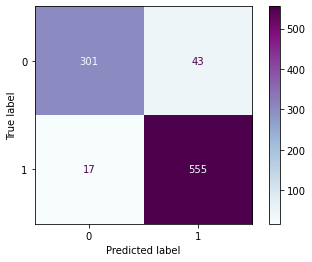

In [57]:
# plot a confusion matrix
plot_confusion_matrix(gs_rf, X_val, y_val, cmap='BuPu', values_format='d');

In [99]:
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Specificity:', spec)

Accuracy: 0.9334061135371179
Recall: 0.9615384615384616
Specificity: 0.8866279069767442


In [62]:
# classification report for the null model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       344
           1       0.93      0.97      0.95       572

    accuracy                           0.93       916
   macro avg       0.94      0.92      0.93       916
weighted avg       0.94      0.93      0.93       916



In [68]:
# get feature importances
pd.Series(gs_rf.best_estimator_.feature_importances_, X.columns).sort_values(ascending=False)[:10]

approval_gov_Strongly Disapprove                 0.276065
pid3_Republican                                  0.179077
ideo5_Liberal                                    0.062807
approval_gov_Strongly Approve                    0.051030
age                                              0.047006
ideo5_Very Liberal                               0.044914
dist                                             0.037558
ideo5_Very Conservative                          0.036985
pid3_Independent                                 0.023902
approval_gov_Disapprove / Somewhat Disapprove    0.020884
dtype: float64

- Random forest and extremely randomized trees performed pretty much the same on the validation data, random forest is slightly better. They performed better than null model accuracy of 62%. 
- Random forest model is overfit with 100% accuracy on train and 93.5% accuracy on test. It could be due to the grid search choosing maximum depth of 'None', which means the nodes are expanded until all leaves are pure. Let's try another grid search without max_depth of 'None'.

### 2. RandomForest 

In [70]:
# split data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [71]:
# instantiate random forest
rf_2 = RandomForestClassifier()

In [73]:
# gridsearch 
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'max_features': ['sqrt', .5],
    'bootstrap': [True, False],
    'random_state': [42]
}

gs_rf = GridSearchCV(rf_2, rf_params, cv=5, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.9257333995694651


{'bootstrap': True,
 'max_depth': 6,
 'max_features': 0.5,
 'n_estimators': 100,
 'random_state': 42}

In [78]:
# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_params_)
print('accuracy on train data:', gs_rf.score(X_train, y_train))
print('accuracy on test data:', gs_rf.score(X_val, y_val))

best score: 0.9257333995694651
best parameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 0.5, 'n_estimators': 100, 'random_state': 42}
accuracy on train data: 0.9421186749180924
accuracy on test data: 0.9334061135371179


In [79]:
# make predictions 
y_pred = gs_rf.predict(X_val)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

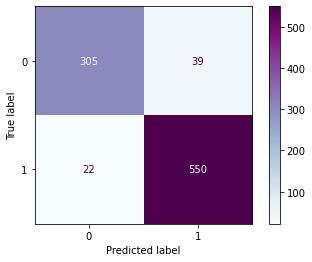

In [80]:
# plot a confusion matrix
plot_confusion_matrix(gs_rf, X_val, y_val, cmap='BuPu', values_format='d');

In [100]:
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Specificity:', spec)

Accuracy: 0.9334061135371179
Recall: 0.9615384615384616
Specificity: 0.8866279069767442


In [83]:
# get feature importances
pd.Series(gs_rf.best_estimator_.feature_importances_, X.columns).sort_values(ascending=False)[:10]

approval_gov_Strongly Disapprove                 0.528053
pid3_Republican                                  0.221600
ideo5_Liberal                                    0.044088
approval_gov_Strongly Approve                    0.034273
approval_gov_Disapprove / Somewhat Disapprove    0.029435
ideo5_Very Liberal                               0.024676
pid3_Independent                                 0.020621
age                                              0.016314
ideo5_Very Conservative                          0.015841
dist                                             0.008754
dtype: float64

In [61]:
# get feature importances
importances= gs_rf.best_estimator_.feature_importances_

In [62]:
# get feature names
names=X_train.columns

In [68]:
# creates the feature importance dataframe
importance_dict = pd.DataFrame({'feature_importances': importances,
                                'features': names})
top10 = importance_dict.nlargest(10, columns=['feature_importances'])
top10

,feature_importances,features
45,0.276065,approval_gov_Strongly Disapprove
7,0.179077,pid3_Republican
46,0.062807,ideo5_Liberal
44,0.051030,approval_gov_Strongly Approve
1,0.047006,age
50,0.044914,ideo5_Very Liberal
0,0.037558,dist
49,0.036985,ideo5_Very Conservative
4,0.023902,pid3_Independent
42,0.020884,approval_gov_Disapprove / Somewhat Disapprove


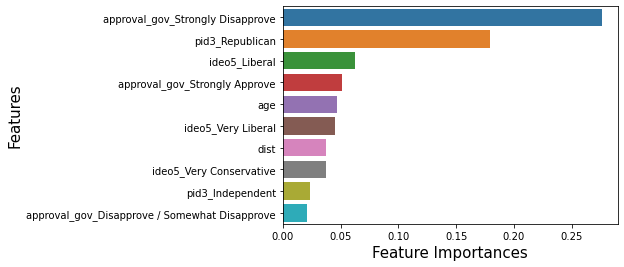

In [80]:
# plot of feature importances
ax = sns.barplot(x="feature_importances", y="features", data=top10)

ax.set_xlabel('Feature Importances',fontsize=15);
ax.set_ylabel('Features',fontsize=15);
plt.show()

- Model has an accuracy of 93% on test and 94% on train. This model is not underfit or overfit, its in the sweet spot.
- approval_gov_Strongly Disapprove feature has a 52.8% importance in this random forest model. 
- pid3_Republican has 22.2% and ideo5_Liberal has 4.4% importances.

-  For a classfication random forest model, feature_importances_ is based on the average decrease in Gini impurity over the decision trees. 
- approval_gov_Strongly Disapprove feature has a 27.6% importance in the random forest model. For this variable, individuals were asked "Do you approve of the way each is doing their job". 
- pid3_Republican has a 17.9% importance. What class or party an individual identifes with has a siginificant impact in how they vote or who they vote for.
- ideo5_Liberal has a 6.3% importance. An individual's political view point is also another big factor that impacts who they vote for. 

# Model Test on 2020 Data

In [88]:
# read 2020 test data
df_test=pd.read_csv('../data/test_data_2020.csv', index_col=0)
df_test

,dist,age,ownhome_Own,ownhome_Rent,pid3_Independent,pid3_Not Sure,pid3_Other,pid3_Republican,gender_Male,educ_4-Year,...,newsint_Some of the time,approval_gov_Disapprove / Somewhat Disapprove,approval_gov_Never Heard / Not Sure,approval_gov_Strongly Approve,approval_gov_Strongly Disapprove,ideo5_Liberal,ideo5_Moderate,ideo5_Not Sure,ideo5_Very Conservative,ideo5_Very Liberal
470768,25,61,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
470779,30,86,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
470780,14,49,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
470781,49,63,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
470815,43,49,1,0,0,0,0,1,1,1,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531711,10,30,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
531715,4,31,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
531716,53,69,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
531725,52,44,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [89]:
# make predictions and save to a dataframe
df_new = pd.DataFrame(gs_rf.predict_proba(df_test))

In [90]:
# find the mean of the predicted probabilities
df_new.mean()

0    0.312987
1    0.687013
dtype: float64

This average of the predicted probabilities show that this model has predicted 69% of people in our sample data will vote for class 1 or democrats and 31% will vote for class 2 or republican. 